## 1. Import Required Libraries

In [172]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Load and Explore Data

In [173]:
# Load the processed data for BAJFINANCE
stock_name = 'BAJFINANCE'
data_path = f'stock_data_daily_processed/{stock_name}_daily_data.csv'

# Read CSV with new multi-index header format
df = pd.read_csv(data_path, header=[0, 1], index_col=0, parse_dates=True)

# Flatten column names (remove multi-index)
df.columns = [col[0] for col in df.columns]

# Rename the index to 'Date' for clarity
df.index.name = 'Date'

print(f"Data shape: {df.shape}")
print(f"\nColumn names:")
print(df.columns.tolist())
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData info:")
print(df.info())
print(f"\nMissing values:")
print(df.isnull().sum().sum())
print(f"\nTarget distribution (Binary):")
target_counts = df['target'].value_counts()
print(f"  Down/Neutral (0): {target_counts.get(0, 0)} ({target_counts.get(0, 0)/len(df)*100:.1f}%)")
print(f"  Up (1): {target_counts.get(1, 0)} ({target_counts.get(1, 0)/len(df)*100:.1f}%)")

Data shape: (1461, 41)

Column names:
['Close', 'High', 'Low', 'Open', 'Volume', 'log_return', 'return_lag_1', 'return_lag_2', 'return_lag_3', 'return_lag_5', 'price_change_5d', 'price_change_10d', 'price_change_20d', 'high_low_ratio', 'open_close_ratio', 'volatility_5d', 'volatility_10d', 'volatility_20d', 'volume_change', 'volume_ma_5', 'volume_ma_20', 'volume_ratio_5d', 'volume_ratio_20d', 'price_volume_trend', 'sma_5', 'sma_10', 'sma_20', 'ema_10', 'ema_20', 'price_to_sma_5', 'price_to_sma_20', 'rsi_14', 'macd', 'macd_signal', 'macd_hist', 'bollinger_upper', 'bollinger_lower', 'bollinger_mid', 'bollinger_width', 'bollinger_position', 'target']

First few rows:
                 Close        High         Low        Open    Volume  \
Date                                                                   
2018-01-30  163.464920  167.414226  162.744219  167.029519   6801040   
2018-01-31  163.411362  164.594687  160.211988  161.424530  13322250   
2018-02-01  168.436874  171.412233  160

## 3. Data Preprocessing

In [174]:
# Remove rows with missing values
df_clean = df.dropna()
print(f"Shape after removing NaN: {df_clean.shape}")

# Separate features and target
feature_cols = [col for col in df_clean.columns if col != 'target']
X = df_clean[feature_cols].values
y = df_clean['target'].values.astype(int)  # Binary: 0 or 1

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Number of features: {len(feature_cols)}")
print(f"\nFeature names:")
print(feature_cols[:10], "...")  # Show first 10

print(f"\nBinary target distribution:")
print(f"  Down/Neutral (0): {np.sum(y == 0)} ({np.sum(y == 0)/len(y)*100:.1f}%)")
print(f"  Up (1): {np.sum(y == 1)} ({np.sum(y == 1)/len(y)*100:.1f}%)")
print(f"  Class balance ratio: {np.sum(y == 1) / np.sum(y == 0):.2f}")

Shape after removing NaN: (1461, 41)

Features shape: (1461, 40)
Target shape: (1461,)
Number of features: 40

Feature names:
['Close', 'High', 'Low', 'Open', 'Volume', 'log_return', 'return_lag_1', 'return_lag_2', 'return_lag_3', 'return_lag_5'] ...

Binary target distribution:
  Down/Neutral (0): 700 (47.9%)
  Up (1): 761 (52.1%)
  Class balance ratio: 1.09


## 4. Create Sequences for LSTM

In [175]:
def create_sequences(X, y, sequence_length):
    """
    Create sequences for LSTM input
    X: features array
    y: target array
    sequence_length: number of time steps to look back
    """
    X_seq, y_seq = [], []
    
    for i in range(len(X) - sequence_length):
        X_seq.append(X[i:i+sequence_length]) # Days i to i+sequence_length-1
        y_seq.append(y[i+sequence_length]) # Day i+sequence_length (next day)
    
    return np.array(X_seq), np.array(y_seq)

# Set sequence length (lookback window)
SEQUENCE_LENGTH = 10

# Create sequences
X_seq, y_seq = create_sequences(X, y, SEQUENCE_LENGTH)

print(f"Sequence shape: {X_seq.shape}")  # (samples, sequence_length, features)
print(f"Target shape: {y_seq.shape}")
print(f"\nBinary target distribution in sequences:")
print(f"  Down/Neutral (0): {np.sum(y_seq == 0)} ({np.sum(y_seq == 0)/len(y_seq)*100:.1f}%)")
print(f"  Up (1): {np.sum(y_seq == 1)} ({np.sum(y_seq == 1)/len(y_seq)*100:.1f}%)")

Sequence shape: (1451, 10, 40)
Target shape: (1451,)

Binary target distribution in sequences:
  Down/Neutral (0): 695 (47.9%)
  Up (1): 756 (52.1%)


## 5. Train-Test Split and Scaling

In [176]:
# Split data temporally (don't shuffle for time series)
train_size = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# Display target distribution
print(f"\nTrain target distribution:")
train_0 = np.sum(y_train == 0)
train_1 = np.sum(y_train == 1)
print(f"  Down/Neutral (0): {train_0} samples ({train_0/len(y_train)*100:.1f}%)")
print(f"  Up (1): {train_1} samples ({train_1/len(y_train)*100:.1f}%)")

print(f"\nTest target distribution:")
test_0 = np.sum(y_test == 0)
test_1 = np.sum(y_test == 1)
print(f"  Down/Neutral (0): {test_0} samples ({test_0/len(y_test)*100:.1f}%)")
print(f"  Up (1): {test_1} samples ({test_1/len(y_test)*100:.1f}%)")

# Scale the features
scaler = StandardScaler()

# Reshape to 2D for scaling
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

# Fit on train, transform both
scaler.fit(X_train_reshaped)
X_train_scaled = scaler.transform(X_train_reshaped).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)

print(f"\nScaled train shape: {X_train_scaled.shape}")
print(f"Scaled test shape: {X_test_scaled.shape}")

Train set: (1160, 10, 40), (1160,)
Test set: (291, 10, 40), (291,)

Train target distribution:
  Down/Neutral (0): 541 samples (46.6%)
  Up (1): 619 samples (53.4%)

Test target distribution:
  Down/Neutral (0): 154 samples (52.9%)
  Up (1): 137 samples (47.1%)

Scaled train shape: (1160, 10, 40)
Scaled test shape: (291, 10, 40)


## 6. Create PyTorch Dataset and DataLoader

In [177]:
class StockDataset(Dataset):
    """Custom Dataset for stock sequences"""
    
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = StockDataset(X_train_scaled, y_train)
test_dataset = StockDataset(X_test_scaled, y_test)

# Create dataloaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False) # shuffle = False due to Time series
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 37
Number of test batches: 10


## 7. Define LSTM Model Architecture

In [182]:
class LSTMModel(nn.Module):
    """
    LSTM model for binary stock price prediction
    """
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super(LSTMModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected layers for binary classification
        self.fc1 = nn.Linear(hidden_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)  # Binary: single output neuron
        self.sigmoid = nn.Sigmoid()  # For binary classification
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights using appropriate methods"""
        # He initialization for layers with ReLU activation
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.zeros_(self.fc1.bias)
        
        # Xavier initialization for output layer
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
        
        # Initialize LSTM weights
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_normal_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                nn.init.zeros_(param.data)
        
    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Get the output from the last time step
        out = out[:, -1, :]
        
        # Apply dropout
        out = self.dropout(out)
        
        # Pass through fully connected layers
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.sigmoid(out)  # Output probability between 0 and 1
        
        return out

# Model hyperparameters
INPUT_SIZE = X_train_scaled.shape[2]  # Number of features
HIDDEN_SIZE = 64
NUM_LAYERS = 2
DROPOUT = 0.5

# Initialize model
model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, DROPOUT).to(device)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Input features: {INPUT_SIZE}")

LSTMModel(
  (lstm): LSTM(40, 64, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total parameters: 64641
Input features: 40


## 8. Define Loss Function and Optimizer

In [183]:
# Calculate class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

# For BCELoss, we'll use pos_weight parameter instead
# pos_weight = weight of positive class (class 1) / weight of negative class (class 0)
pos_weight = torch.FloatTensor([class_weights[1] / class_weights[0]]).to(device)

print(f"Class weights: {class_weights_dict}")
print(f"  Down/Neutral (0): {class_weights[0]:.4f}")
print(f"  Up (1): {class_weights[1]:.4f}")
print(f"Positive class weight for BCE: {pos_weight.item():.4f}")

# Loss function - Binary Cross Entropy with positive class weighting
criterion = nn.BCELoss()  # Binary Cross Entropy for binary classification

# Optimizer - Adam
LEARNING_RATE = 0.001
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5,     
    patience=10,
    verbose=True,
    min_lr=1e-6
)

print(f"\nCriterion: {criterion}")
print(f"Optimizer: Adam (lr={LEARNING_RATE})")
print(f"Scheduler: ReduceLROnPlateau")

Class weights: {0: 1.0720887245841035, 1: 0.9369951534733441}
  Down/Neutral (0): 1.0721
  Up (1): 0.9370
Positive class weight for BCE: 0.8740

Criterion: BCELoss()
Optimizer: Adam (lr=0.001)
Scheduler: ReduceLROnPlateau


## 9. Training and Evaluation Functions

In [184]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Convert y_batch to float and reshape for BCE loss
        y_batch = y_batch.float().unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item() * X_batch.size(0)
        predicted = (outputs > 0.5).float()  # Threshold at 0.5
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    """Evaluate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Convert y_batch to float and reshape for BCE loss
            y_batch = y_batch.float().unsqueeze(1)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            running_loss += loss.item() * X_batch.size(0)
            predicted = (outputs > 0.5).float()
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            
            all_preds.extend(predicted.cpu().numpy().flatten())
            all_labels.extend(y_batch.cpu().numpy().flatten())
            all_probs.extend(outputs.cpu().numpy().flatten())
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc, np.array(all_preds), np.array(all_labels), np.array(all_probs)

print("Training and evaluation functions defined for binary classification.")

Training and evaluation functions defined for binary classification.


## 10. Train the Model

In [185]:
NUM_EPOCHS = 50

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_loss = float('inf')
best_val_acc = 0.0
best_epoch = 0

print("="*70)
print(f"TRAINING: {stock_name} | Epochs: {NUM_EPOCHS} | Binary Classification")
print("="*70)
print(f"{'Ep':<4} {'TrLoss':<8} {'TrAcc':<8} {'VLoss':<8} {'VAcc':<8} {'Status':<25}")
print("-"*70)

for epoch in range(NUM_EPOCHS):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Evaluate
    val_loss, val_acc, val_preds, val_labels, val_probs = evaluate(model, test_loader, criterion, device)
    
    # Update learning rate based on val_loss
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Determine status - save based on best validation metrics
    status = ""
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_lstm_model.pth')
        status = "✓ (loss)"
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        torch.save(model.state_dict(), 'best_val_acc_model.pth')
        status += " ✓ (acc)"
    
    # Check if LR changed
    if new_lr < old_lr:
        status += f" LR:{new_lr:.1e}"
    
    # Print epoch results
    print(f"{epoch+1:<4} {train_loss:<8.4f} {train_acc:<8.4f} {val_loss:<8.4f} {val_acc:<8.4f} {status:<25}")
    
    # Monitor prediction distribution every 10 epochs
    if (epoch + 1) % 10 == 0 or epoch == 0:
        pred_0 = np.sum(val_preds == 0)
        pred_1 = np.sum(val_preds == 1)
        print(f"      -> Val predictions: 0={pred_0}, 1={pred_1} ({pred_1/(pred_0+pred_1)*100:.1f}% positive)")
        
        # Show actual distribution
        label_0 = np.sum(val_labels == 0)
        label_1 = np.sum(val_labels == 1)
        print(f"      -> Actual labels:   0={label_0}, 1={label_1} ({label_1/(label_0+label_1)*100:.1f}% positive)")
        
        # Average prediction probability
        print(f"      -> Avg prediction prob: {val_probs.mean():.3f} (std: {val_probs.std():.3f})")
        
        # Check if model is stuck
        if pred_0 == 0 or pred_1 == 0:
            print(f"      -> WARNING: Model predicting only one class!")

print("="*70)
print(f"Training complete! {NUM_EPOCHS} epochs")
print(f"Best val loss: {best_val_loss:.4f}")
print(f"Best val accuracy: {best_val_acc:.4f} @ epoch {best_epoch}")
print("="*70)

TRAINING: BAJFINANCE | Epochs: 50 | Binary Classification
Ep   TrLoss   TrAcc    VLoss    VAcc     Status                   
----------------------------------------------------------------------
1    0.6972   0.4905   0.7006   0.4708   ✓ (loss) ✓ (acc)         
      -> Val predictions: 0=22, 1=269 (92.4% positive)
      -> Actual labels:   0=154, 1=137 (47.1% positive)
      -> Avg prediction prob: 0.527 (std: 0.017)
1    0.6972   0.4905   0.7006   0.4708   ✓ (loss) ✓ (acc)         
      -> Val predictions: 0=22, 1=269 (92.4% positive)
      -> Actual labels:   0=154, 1=137 (47.1% positive)
      -> Avg prediction prob: 0.527 (std: 0.017)
2    0.6908   0.5353   0.7000   0.4742   ✓ (loss) ✓ (acc)         
3    0.6872   0.5293   0.7056   0.4777    ✓ (acc)                 
2    0.6908   0.5353   0.7000   0.4742   ✓ (loss) ✓ (acc)         
3    0.6872   0.5293   0.7056   0.4777    ✓ (acc)                 
4    0.6911   0.5431   0.7071   0.4742                            
5    0.6913   0

## 11. Plot Training History

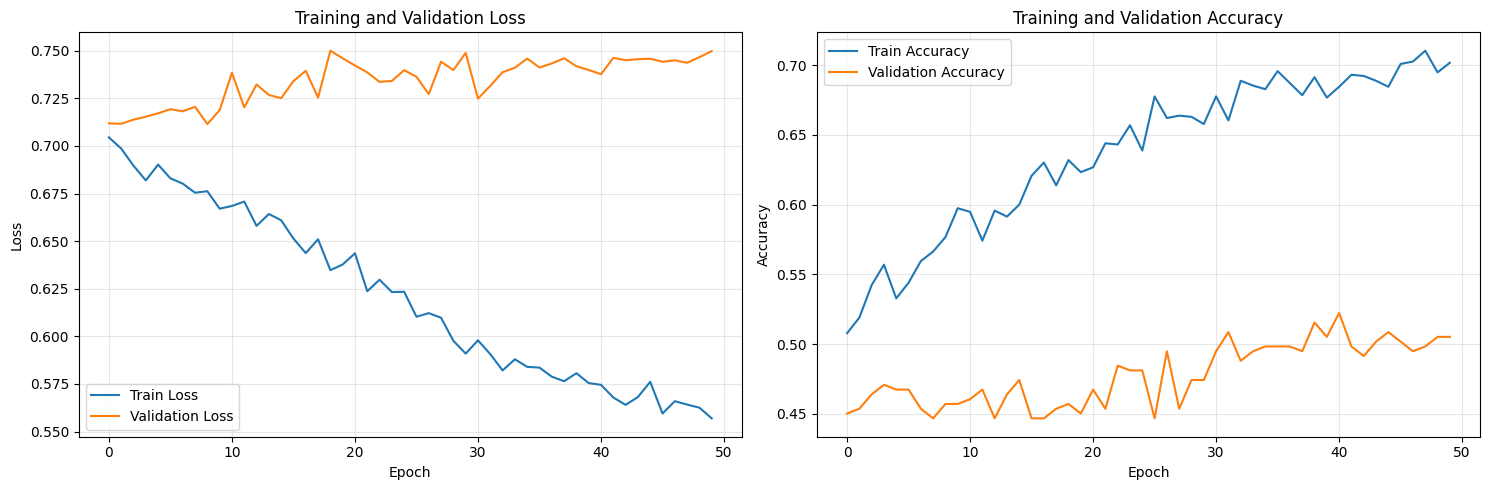

In [144]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot accuracy
axes[1].plot(history['train_acc'], label='Train Accuracy')
axes[1].plot(history['val_acc'], label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 12. Load Best Model and Final Evaluation

In [159]:
# Load best model
model.load_state_dict(torch.load('best_val_acc_model.pth'))
model.eval()

# Evaluate on test set
test_loss, test_acc, test_preds, test_labels, test_probs = evaluate(model, test_loader, criterion, device)

print("="*70)
print("FINAL TEST SET RESULTS (BINARY CLASSIFICATION)")
print("="*70)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print()

# Convert predictions to int for classification report
test_preds_int = test_preds.astype(int)
test_labels_int = test_labels.astype(int)

# Classification report
print("Classification Report:")
print(classification_report(test_labels_int, test_preds_int, target_names=['Down/Neutral (0)', 'Up (1)']))

# Additional metrics
precision = precision_score(test_labels_int, test_preds_int)
recall = recall_score(test_labels_int, test_preds_int)
f1 = f1_score(test_labels_int, test_preds_int)

print(f"\nMetrics for class 1 (Up):")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Prediction distribution
print(f"\nPrediction distribution:")
print(f"  Down/Neutral (0): {np.sum(test_preds_int == 0)} ({np.sum(test_preds_int == 0)/len(test_preds_int)*100:.1f}%)")
print(f"  Up (1): {np.sum(test_preds_int == 1)} ({np.sum(test_preds_int == 1)/len(test_preds_int)*100:.1f}%)")
print(f"\nActual distribution:")
print(f"  Down/Neutral (0): {np.sum(test_labels_int == 0)} ({np.sum(test_labels_int == 0)/len(test_labels_int)*100:.1f}%)")
print(f"  Up (1): {np.sum(test_labels_int == 1)} ({np.sum(test_labels_int == 1)/len(test_labels_int)*100:.1f}%)")

FINAL TEST SET RESULTS (BINARY CLASSIFICATION)
Test Loss: 0.7417
Test Accuracy: 0.4914

Classification Report:
                  precision    recall  f1-score   support

Down/Neutral (0)       0.53      0.37      0.44       154
          Up (1)       0.47      0.63      0.54       137

        accuracy                           0.49       291
       macro avg       0.50      0.50      0.49       291
    weighted avg       0.50      0.49      0.48       291


Metrics for class 1 (Up):
Precision: 0.4699
Recall: 0.6277
F1-Score: 0.5375

Prediction distribution:
  Down/Neutral (0): 108 (37.1%)
  Up (1): 183 (62.9%)

Actual distribution:
  Down/Neutral (0): 154 (52.9%)
  Up (1): 137 (47.1%)


## 13. Confusion Matrix

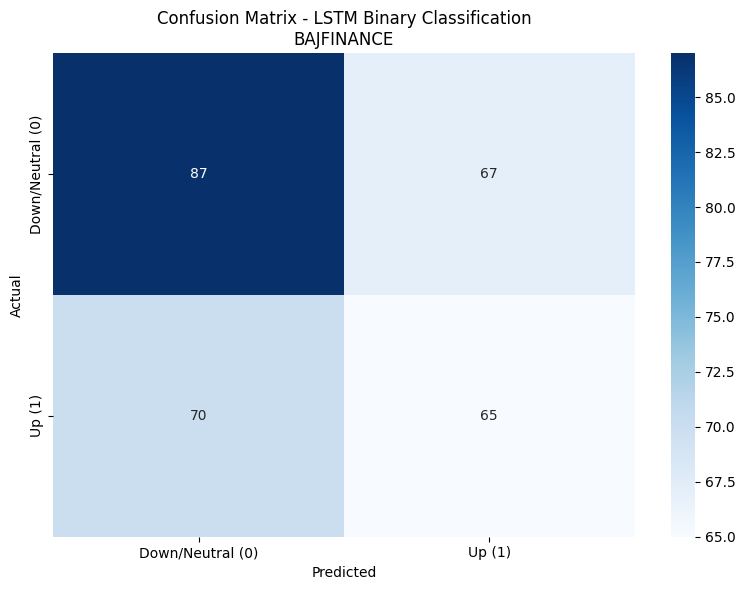


Confusion Matrix (Percentages):
                Pred 0    Pred 1
Actual 0:       56.5%     43.5%
Actual 1:       51.9%     48.1%


In [103]:
# Compute confusion matrix
cm = confusion_matrix(test_labels_int, test_preds_int)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Down/Neutral (0)', 'Up (1)'],
            yticklabels=['Down/Neutral (0)', 'Up (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - LSTM Binary Classification\n{stock_name}')
plt.tight_layout()
plt.show()

# Calculate percentage
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
print("\nConfusion Matrix (Percentages):")
print(f"                Pred 0    Pred 1")
print(f"Actual 0:       {cm_percent[0,0]:.1f}%     {cm_percent[0,1]:.1f}%")
print(f"Actual 1:       {cm_percent[1,0]:.1f}%     {cm_percent[1,1]:.1f}%")

## 14. Model Summary and Key Insights

In [104]:
print("="*70)
print("LSTM BINARY CLASSIFICATION MODEL SUMMARY")
print("="*70)
print(f"\nStock: {stock_name}")
print(f"Data Shape: {df_clean.shape}")
print(f"Sequence Length: {SEQUENCE_LENGTH}")
print(f"Train Samples: {len(X_train)}")
print(f"Test Samples: {len(X_test)}")
print(f"\nModel Architecture:")
print(f"  - Input Features: {INPUT_SIZE}")
print(f"  - Hidden Size: {HIDDEN_SIZE}")
print(f"  - Number of LSTM Layers: {NUM_LAYERS}")
print(f"  - Dropout: {DROPOUT}")
print(f"  - Output: Binary (1 neuron with sigmoid)")
print(f"  - Total Parameters: {sum(p.numel() for p in model.parameters())}")
print(f"\nTraining Configuration:")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Learning Rate: {LEARNING_RATE}")
print(f"  - Epochs Trained: {len(history['train_loss'])}")
print(f"  - Optimizer: Adam")
print(f"  - Loss Function: Binary Cross Entropy")
print(f"\nPerformance Metrics:")
print(f"  - Test Accuracy: {test_acc:.4f}")
print(f"  - Test Loss: {test_loss:.4f}")
print(f"  - Precision (Up class): {precision:.4f}")
print(f"  - Recall (Up class): {recall:.4f}")
print(f"  - F1-Score (Up class): {f1:.4f}")
print("="*70)

LSTM BINARY CLASSIFICATION MODEL SUMMARY

Stock: BAJFINANCE
Data Shape: (1461, 41)
Sequence Length: 20
Train Samples: 1152
Test Samples: 289

Model Architecture:
  - Input Features: 40
  - Hidden Size: 128
  - Number of LSTM Layers: 2
  - Dropout: 0.3
  - Output: Binary (1 neuron with sigmoid)
  - Total Parameters: 227457

Training Configuration:
  - Batch Size: 32
  - Learning Rate: 0.001
  - Epochs Trained: 100
  - Optimizer: Adam
  - Loss Function: Binary Cross Entropy

Performance Metrics:
  - Test Accuracy: 0.5260
  - Test Loss: 0.7572
  - Precision (Up class): 0.4924
  - Recall (Up class): 0.4815
  - F1-Score (Up class): 0.4869


## ⚠️ Model Performance Analysis: SEVERE OVERFITTING DETECTED

### Current Results:
- **Training Accuracy**: 86% ✅
- **Validation Accuracy**: 48-52% ❌ (Random Guessing!)
- **Training Loss**: Decreasing ✅
- **Validation Loss**: INCREASING from 0.70 → 1.76 ❌

**This is classic overfitting** - the model memorized training data but cannot generalize.

---

## 🎯 ROOT CAUSES:

1. **Model Too Complex**: ~75K parameters for ~1K training samples
   - Need 10+ samples per parameter → requires 750K samples!
   
2. **Should Have Stopped at Epoch 24**: Best val accuracy was 52.6% at epoch 24
   - Training for 76 more epochs just made overfitting worse

3. **Stock Prediction is Hard**: 50-55% accuracy is actually normal for daily stock prediction

---

## 💡 IMMEDIATE FIXES (Try These Next):

### **1. SIMPLIFY THE MODEL** (Most Critical!)
Change in cell 11:
```python
HIDDEN_SIZE = 32      # Reduce from 128 (4x simpler)
NUM_LAYERS = 1        # Reduce from 2
DROPOUT = 0.5         # Increase from 0.3 (more regularization)
```

### **2. ADD EARLY STOPPING**
Add to cell 14 (training loop):
```python
# Stop training when validation stops improving
patience = 15
epochs_no_improve = 0
if val_acc <= best_val_acc:
    epochs_no_improve += 1
    if epochs_no_improve >= patience:
        print("Early stopping!")
        break
```

### **3. REDUCE SEQUENCE LENGTH**
Change in cell 7:
```python
SEQUENCE_LENGTH = 10  # Reduce from 20 → gives 2x more samples
```

### **4. COMBINE ALL STOCKS** (Most Data!)
- Train one model on all 10 stocks combined
- This gives 10x more training data
- Much better for deep learning

---

## 📊 Realistic Expectations:

| Validation Accuracy | Interpretation |
|---------------------|----------------|
| 48-50% | Random guessing (coin flip) |
| 50-52% | Slight edge (current model) |
| 52-55% | **Decent model** (potentially profitable) |
| 55-58% | Good model (rare for daily) |
| 58%+ | Excellent (very rare - check for data leakage!) |

**Your current 52.6% is barely above random, but it's a START!**

---

## 🔄 Recommended Action Plan:

1. ✅ **Run simpler model first** (HIDDEN=32, LAYERS=1, DROPOUT=0.5)
2. ✅ **Add early stopping** (patience=15)  
3. ✅ **Reduce sequence** to 10 days
4. ✅ **Target 53-55% validation accuracy**
5. ✅ **Then add sentiment features** to see if accuracy improves

If you get to 55%+ consistently, that's when you can start thinking about trading strategies!